In [115]:
!pip install geodatasets
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 74.1 MB/s eta 0:00:00


In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import geodatasets
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
%matplotlib inline


In [117]:
pledges_df = pd.read_csv("https://github.com/siddharthgundala/Final-Project/raw/refs/heads/main/Pledges.csv",encoding="ISO-8859-1", sep=';')
funds_df = pd.read_csv("https://github.com/siddharthgundala/Final-Project/raw/refs/heads/main/Fund%20Status.csv",encoding="ISO-8859-1", sep=';')
projects_df = pd.read_csv("https://github.com/siddharthgundala/Final-Project/raw/refs/heads/main/Projects.csv",encoding="ISO-8859-1", sep=';')
co2_df = pd.read_csv("https://github.com/siddharthgundala/Final-Project/raw/refs/heads/main/annual-co2-emissions-per-country.csv")
methane_df = pd.read_csv("https://github.com/siddharthgundala/Final-Project/raw/refs/heads/main/methane-emissions.csv")
cfvi_df= pd.read_csv("https://github.com/siddharthgundala/Final-Project/raw/refs/heads/main/CFVI.csv")

In [118]:
print("Pledges:", pledges_df.shape)
print("Fund Status:", funds_df.shape)
print("Projects:", projects_df.shape)
print("CO2:", co2_df.shape)
print("Methane:", methane_df.shape)
print("CFVI:", cfvi_df.shape)

Pledges: (1257, 13)
Fund Status: (31, 8)
Projects: (3800, 25)
CO2: (29137, 4)
Methane: (37410, 4)
CFVI: (188, 3)


In [119]:
print(co2_df.columns)
print(methane_df.columns)
print(cfvi_df.columns)

Index(['Entity', 'Code', 'Year', 'Annual CO₂ emissions'], dtype='object')
Index(['Entity', 'Code', 'Year',
       'Annual methane emissions in CO₂ equivalents'],
      dtype='object')
Index(['Rank', 'Country', 'Index Score'], dtype='object')


In [120]:
co2_total = (
    co2_df.groupby('Entity')['Annual CO₂ emissions']
          .sum(min_count=1)
          .reset_index()
          .rename(columns={
              'Entity': 'Country',
              'Annual CO₂ emissions': 'Total_CO2_emissions'
          })
)
print(co2_total)

               Country  Total_CO2_emissions
0          Afghanistan         2.368414e+08
1               Africa         5.259617e+10
2         Africa (GCP)         5.259576e+10
3              Albania         3.041735e+08
4              Algeria         5.263690e+09
..                 ...                  ...
242  Wallis and Futuna         8.337840e+05
243              World         1.812356e+12
244              Yemen         6.958331e+08
245             Zambia         2.739307e+08
246           Zimbabwe         8.150887e+08

[247 rows x 2 columns]


In [121]:
methane_total = (
    methane_df.groupby('Entity')['Annual methane emissions in CO₂ equivalents']
              .sum(min_count=1)
              .reset_index()
              .rename(columns={
                  'Entity': 'Country',
                  'Annual methane emissions in CO₂ equivalents': 'Total_Methane_emissions'
              })
)
print(methane_total)

         Country  Total_Methane_emissions
0    Afghanistan             1.404239e+09
1         Africa             8.047920e+10
2        Albania             3.365854e+08
3        Algeria             4.756343e+09
4        Andorra             7.747589e+06
..           ...                      ...
210      Vietnam             6.525608e+09
211        World             7.514771e+11
212        Yemen             9.156567e+08
213       Zambia             1.018995e+09
214     Zimbabwe             8.848732e+08

[215 rows x 2 columns]


In [122]:
emissions_df = pd.merge(co2_total, methane_total, on='Country', how='inner')

emissions_df.fillna(0, inplace=True)

In [123]:
emissions_df['Total_GHG_emissions'] = (
    emissions_df['Total_CO2_emissions'] + emissions_df['Total_Methane_emissions']
)

emissions_df.head()

,Country,Total_CO2_emissions,Total_Methane_emissions,Total_GHG_emissions
0,Afghanistan,2.368414e+08,1.404239e+09,1.641080e+09
1,Africa,5.259617e+10,8.047920e+10,1.330754e+11
2,Albania,3.041735e+08,3.365854e+08,6.407589e+08
3,Algeria,5.263690e+09,4.756343e+09,1.002003e+10
4,Andorra,1.623590e+07,7.747589e+06,2.398349e+07


In [124]:
missing_countries = set(cfvi_df['Country']) - set(emissions_df['Country'])
print("Missing from emissions_df:", sorted(missing_countries))

Missing from emissions_df: ['Brunei Darussalam', 'Cabo Verde', 'Congo DR', 'Czech Republic', 'Côte d’Ivoire', 'Korea Republic of', 'Lao PDR', 'Marshall Islands', 'Micronesia', 'Moldova Republic of', 'Palestine', 'Russian Federation', 'Timor-Leste', 'Türkiye', 'United States of America', 'Viet Nam']


In [133]:
#standardize country function
import pycountry
from difflib import get_close_matches

def standardize_country_name(name):
    try:
        
        return pycountry.countries.lookup(name).name
    except:
      
        matches = get_close_matches(name, [c.name for c in pycountry.countries], n=1, cutoff=0.8)
        return matches[0] if matches else name

In [132]:
#Standardize country names

emissions_df['Country_standardized'] = emissions_df['Country'].apply(standardize_country_name)
cfvi_df['Country_standardized'] = cfvi_df['Country'].apply(standardize_country_name)

print(emissions_df.columns)
print(cfvi_df.columns)

emissions_countries = set(emissions_df['Country_standardized'])
cfvi_countries = set(cfvi_df['Country_standardized'])

matched = emissions_countries & cfvi_countries
unmatched_in_emissions = cfvi_countries - emissions_countries
unmatched_in_cfvi = emissions_countries - cfvi_countries

print(f"✅ Matched countries: {len(matched)}")
print(f"❌ Missing from emissions: {sorted(unmatched_in_emissions)}")
print(f"❌ Missing from CFVI: {sorted(unmatched_in_cfvi)}")

Index(['Country', 'Total_CO2_emissions', 'Total_Methane_emissions',
       'Total_GHG_emissions', 'Country_standardized'],
      dtype='object')
Index(['Rank', 'Country', 'Index Score', 'Country_standardized'], dtype='object')
✅ Matched countries: 179
❌ Missing from emissions: ['Brunei Darussalam', 'Congo DR', 'Lao PDR', 'Marshall Islands', 'Micronesia', 'Palestine', 'Russian Federation', 'Timor-Leste', 'Türkiye']
❌ Missing from CFVI: ['Africa', 'Andorra', 'Asia', 'Asia (excl. China and India)', 'Brunei', 'Cook Islands', 'Cuba', 'Democratic Republic of Congo', 'East Timor', 'Europe', 'Europe (excl. EU-27)', 'Europe (excl. EU-28)', 'European Union (27)', 'European Union (28)', 'High-income countries', 'Hong Kong', "Korea, Democratic People's Republic of", "Lao People's Democratic Republic", 'Liechtenstein', 'Low-income countries', 'Lower-middle-income countries', 'Macao', 'Micronesia (country)', 'Niue', 'North America', 'North America (excl. USA)', 'Oceania', 'Russia', 'Taiwan, Province

In [128]:
#filter emissions by CFVI index countries

filtered_emissions_df = emissions_df[emissions_df['Country'].isin(cfvi_df['Country'])]

print("CFVI:", cfvi_df.shape)
print("Filtered:", filtered_emissions_df.shape)



CFVI: (188, 4)
Filtered: (172, 5)


In [111]:
#merge CFVI and emissions

emissions_and_cfvi = pd.merge(
    filtered_emissions_df,
    cfvi_df[['Country', 'Index Score']],
    on='Country',
    how='left'
)
emissions_and_cfvi.head()

,Country,Total_CO2_emissions,Total_Methane_emissions,Total_GHG_emissions,Index Score
0,Afghanistan,2.368414e+08,1.404239e+09,1.641080e+09,52.2
1,Albania,3.041735e+08,3.365854e+08,6.407589e+08,47.2
2,Algeria,5.263690e+09,4.756343e+09,1.002003e+10,39.6
3,Angola,7.153404e+08,2.795125e+09,3.510466e+09,87.7
4,Antigua and Barbuda,2.626119e+07,6.919378e+06,3.318057e+07,51.3


In [ ]:
#bar chart of top 20 emitters

top20_emitters = emissions_and_cfvi.sort_values(by='Total_GHG_emissions', ascending=False).head(20)


plt.figure(figsize=(12, 6))
plt.barh(top_emitters['Country'], top_emitters['Total_GHG_emissions'], color='darkred')
plt.xlabel("Total GHG Emissions (tons CO₂e)")
plt.title("Top 20 Greenhouse Gas Emitting Countries")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [83]:
world = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/all_world.geojson')

print(world.columns)

Index(['name', 'geometry'], dtype='object')


In [137]:
merged = world.merge(emissions_df, left_on="name", right_on="Country", how="left")
print(merged.columns)


Index(['name', 'geometry', 'Country', 'Total_CO2_emissions',
       'Total_Methane_emissions', 'Total_GHG_emissions',
       'Country_standardized'],
      dtype='object')


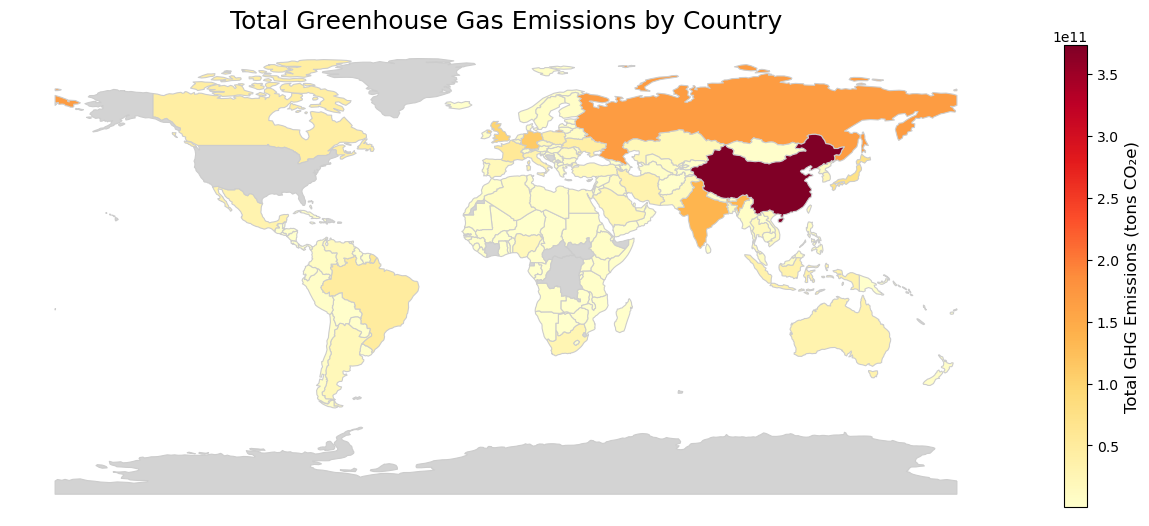

In [138]:
fig, ax = plt.subplots(figsize=(16, 10))


merged.plot(
    column='Total_GHG_emissions',
    cmap='YlOrRd',               
    linewidth=0.8,               
    edgecolor='0.8',            
    legend=True,                
    ax=ax,
    missing_kwds={
        "color": "lightgrey",    
        "label": "No data",
    },
    legend_kwds={
        'label': "Total GHG Emissions (tons CO₂e)",
        'shrink': 0.6
    }
)


ax.set_title("Total Historical GHG Emissions Map", fontsize=18)
ax.axis('off')

plt.show()